# Project 1

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

import random
# Set global seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## EDA

### General Observations

In [2]:
df = pd.read_csv('data/mimic_train.csv')

In [3]:
df.head()

,Unnamed: 0,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,49121,MICU,6.1397
1,15798,0,44346,140114,250021,74.0,114.0,92.204082,87.0,160.0,...,-56421.13544,EMERGENCY,Private,EPISCOPALIAN,DIVORCED,WHITE,S/P PEDESTRIAN STRUCK,80620,TSICU,10.2897
2,2129,0,92438,118589,288511,59.0,89.0,70.581395,88.0,160.0,...,-60754.35504,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,STERNAL WOUND INFECTION,99859,CSRU,5.8080
3,17053,1,83663,125553,278204,75.0,86.0,80.400000,74.0,102.0,...,-56609.91884,EMERGENCY,Private,CATHOLIC,MARRIED,BLACK/AFRICAN AMERICAN,SEPSIS,27652,MICU,2.3536
4,11609,0,85941,181409,292581,77.0,107.0,91.020408,95.0,150.0,...,-59200.37377,EMERGENCY,Medicaid,NOT SPECIFIED,DIVORCED,WHITE,BILE LEAK,9974,MICU,19.3935


In [4]:
# rename target column and check for null values
df.rename(columns={"HOSPITAL_EXPIRE_FLAG"   : "target", "subject_id" : "SUBJECT_ID", "hadm_id" : "HADM_ID"}, inplace=True)
df["target"].isnull().sum()

np.int64(0)

There are no missing values in Target ! 

In [5]:
# print class distribution
print(round(df['target'].value_counts(normalize=True),2))

target
0    0.89
1    0.11
Name: proportion, dtype: float64


The target variable is highly imbalanced:
Class 0 represents 89% of the data, while Class 1 only accounts for 11%.
This imbalance may affect model performance, especially for minority class prediction.


In [6]:
# explore the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      8000 non-null   int64  
 1   target          8000 non-null   int64  
 2   SUBJECT_ID      8000 non-null   int64  
 3   HADM_ID         8000 non-null   int64  
 4   icustay_id      8000 non-null   int64  
 5   HeartRate_Min   7167 non-null   float64
 6   HeartRate_Max   7167 non-null   float64
 7   HeartRate_Mean  7167 non-null   float64
 8   SysBP_Min       7160 non-null   float64
 9   SysBP_Max       7160 non-null   float64
 10  SysBP_Mean      7160 non-null   float64
 11  DiasBP_Min      7160 non-null   float64
 12  DiasBP_Max      7160 non-null   float64
 13  DiasBP_Mean     7160 non-null   float64
 14  MeanBP_Min      7167 non-null   float64
 15  MeanBP_Max      7167 non-null   float64
 16  MeanBP_Mean     7167 non-null   float64
 17  RespRate_Min    7167 non-null   f

Several columns contain missing values, especially among vital signs and clinical measurements:
- Heart rate, blood pressure, respiratory rate, temperature, and SpO2 have ~10% missing data.
- Glucose is nearly complete, with only minor gaps.
- Demographic and administrative fields like MARITAL_STATUS, DOD, and DEATHTIME have substantial missingness.
These missing values will need to be addressed before modeling — either through imputation or exclusion.

Moreover, The columns 'DOD', 'DISCHTIME', 'DEATHTIME', and 'LOS' should be excluded from model training , as they contain information that becomes available only after the patient's death and would not be accessible prior to that event.

### Explore Missing Values

In [7]:
missing_counts = df.isna().sum() / len(df['target'])
missing_counts = missing_counts[missing_counts > 0]
print(missing_counts)

HeartRate_Min     0.104125
HeartRate_Max     0.104125
HeartRate_Mean    0.104125
SysBP_Min         0.105000
SysBP_Max         0.105000
SysBP_Mean        0.105000
DiasBP_Min        0.105000
DiasBP_Max        0.105000
DiasBP_Mean       0.105000
MeanBP_Min        0.104125
MeanBP_Max        0.104125
MeanBP_Mean       0.104125
RespRate_Min      0.104125
RespRate_Max      0.104125
RespRate_Mean     0.104125
TempC_Min         0.118250
TempC_Max         0.118250
TempC_Mean        0.118250
SpO2_Min          0.105125
SpO2_Max          0.105125
SpO2_Mean         0.105125
Glucose_Min       0.012250
Glucose_Max       0.012250
Glucose_Mean      0.012250
DOD               0.645250
DEATHTIME         0.885875
MARITAL_STATUS    0.036500
dtype: float64


In [8]:
# explore missing values with respect to target variable
group_missing = df.groupby('target').apply(lambda g: g.isna().sum())
group_missing

,Unnamed: 0,target,SUBJECT_ID,HADM_ID,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
target,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,746,746,746,751,751,...,0,0,0,0,214,0,0,0,0,0
1,0,0,0,0,0,87,87,87,89,89,...,0,0,0,0,78,0,0,0,0,0


Many clinical features (e.g., HeartRate, BloodPressure, TempC) have ~10% missing values overall.
However, since class 1 (the minority class) only represents 11% of the data, removing rows with missing values would disproportionately reduce class 1 samples.

To preserve class balance, we will impute missing values during preprocessing instead of dropping them.

### Explore Numeric Columns

In [9]:
# create histograms for numeric columns
def plot_numeric_histograms(df, charts_per_row=5, bins=20):
    numeric_cols = df.select_dtypes(include='number').columns
    n = len(numeric_cols)
    
    if n == 0:
        print("No numeric columns to plot.")
        return

    # Calculate number of rows needed
    rows = math.ceil(n / charts_per_row)
    fig, axes = plt.subplots(nrows=rows, ncols=charts_per_row, figsize=(charts_per_row * 4, rows * 3))
    
    # Flatten axes for easy iteration
    axes = axes.flatten() if n > 1 else [axes]

    # Plot each histogram
    for i, col in enumerate(numeric_cols):
        df[col].plot.hist(ax=axes[i], bins=bins, title=col)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

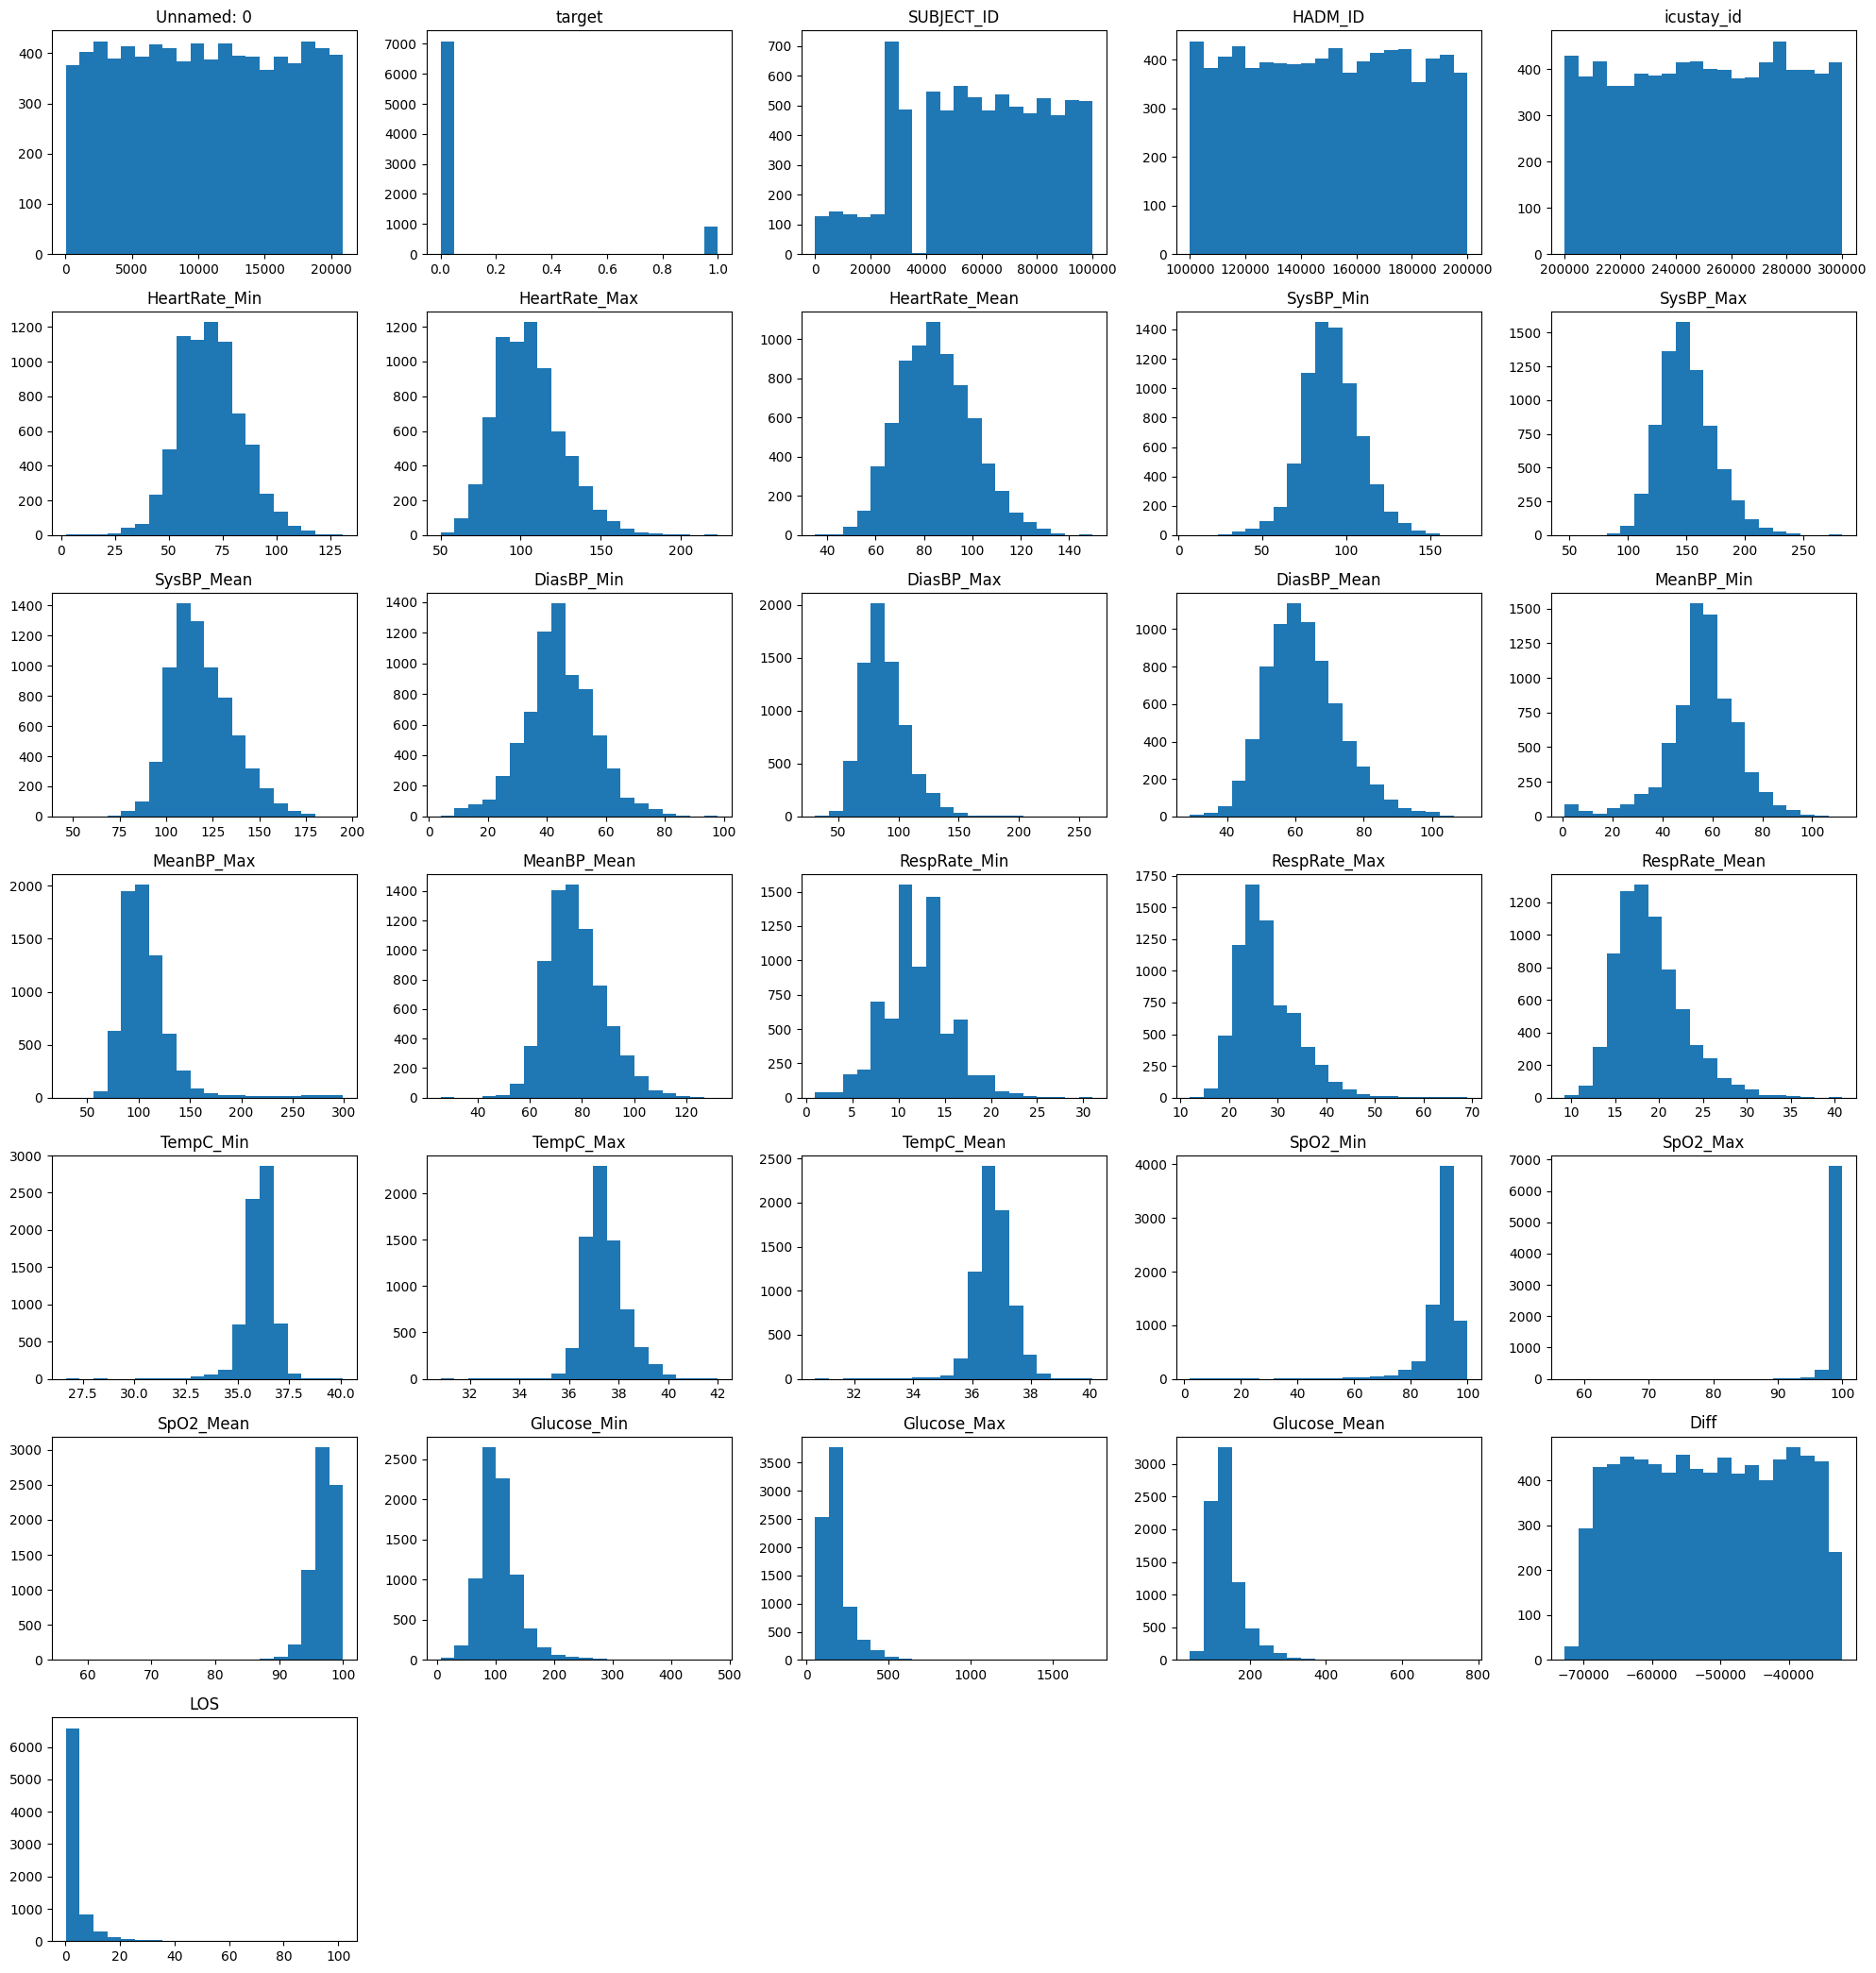

In [10]:
# plot histograms for numeric columns
plot_numeric_histograms(df)

- Based on the histograms, the numeric features appear to follow expected distributions without extreme outliers.
- Most values fall within clinically plausible ranges, suggesting the data is clean and well-behaved for modeling.

### Expolore Date Columns

In [11]:
# cast date columns to datetime
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], errors='coerce')

In [12]:
# define a function that draws histogram for a given column
def histogram(df, column_name, title):
    plt.figure(figsize=(6,4))
    df[column_name].hist(bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

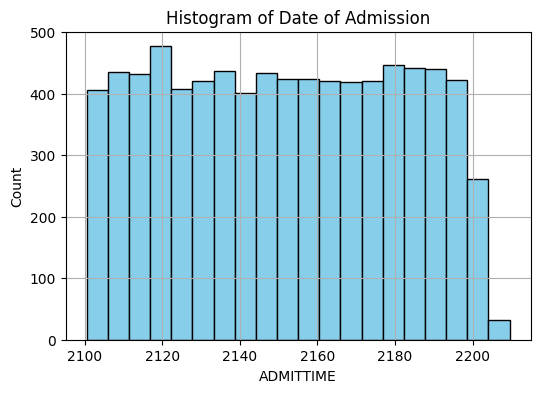

In [13]:
# plot histogram for ADMITTIME 
histogram(df, 'ADMITTIME', 'Histogram of Date of Admission')

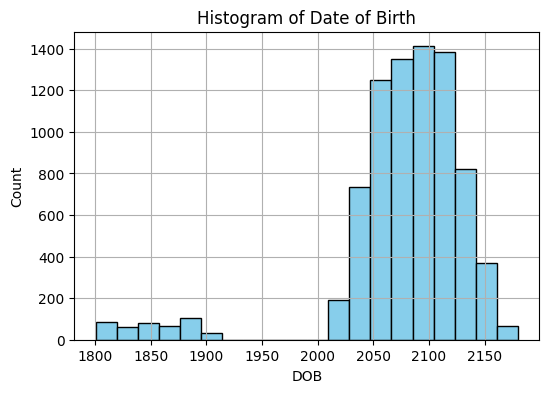

In [14]:
# plot histogram for DOB
histogram(df, 'DOB', 'Histogram of Date of Birth')

In [15]:
subset = df[df['DOB'] < pd.to_datetime('2000-01-01')]
print(subset.groupby('target')['DOB'].count())

target
0    359
1     68
Name: DOB, dtype: int64


The 'Date of Birth' column contains clear outliers, with 68 of them concentrated in class 1.
This issue stems from unrealistic date combinations — for example, 'DOB' values from the 1800s paired with 'ADMITTIME' values starting in the 2100s,
which implies patients over 300 years old. These anomalies distort age-related features.

Since class 1 is already underrepresented, removing these rows would further worsen the class imbalance.
To preserve minority class integrity, we should handle these outliers carefully — by flagging or imputing them — rather than deleting.

### Explore Categorical Columns

In [16]:
print(df['GENDER'].value_counts(), '\n')
print(df['ADMISSION_TYPE'].value_counts(), '\n')
print(df['INSURANCE'].value_counts(), '\n')
print(df['FIRST_CAREUNIT'].value_counts(), '\n')
print(df['ETHNICITY'].value_counts())
print(df['ICD9_diagnosis'].value_counts(), '\n')
print(df['DIAGNOSIS'].value_counts(), '\n')

GENDER
M    4479
F    3521
Name: count, dtype: int64 

ADMISSION_TYPE
EMERGENCY    6809
ELECTIVE     1104
URGENT         87
Name: count, dtype: int64 

INSURANCE
Medicare      4499
Private       2371
Medicaid       807
Government     250
Self Pay        73
Name: count, dtype: int64 

FIRST_CAREUNIT
MICU     3291
SICU     1567
CSRU     1184
TSICU    1007
CCU       951
Name: count, dtype: int64 

ETHNICITY
WHITE                                                       5735
BLACK/AFRICAN AMERICAN                                       758
HISPANIC OR LATINO                                           232
UNABLE TO OBTAIN                                             221
UNKNOWN/NOT SPECIFIED                                        218
OTHER                                                        190
ASIAN                                                        106
PATIENT DECLINED TO ANSWER                                    71
ASIAN - CHINESE                                               66
HISPANI

In [17]:
# print distinct values count for categorical columns
print("ETHNICITY : ", len(df['ETHNICITY'].unique()), '\n')
print("ICD9_diagnosis : ", len(df['ICD9_diagnosis'].unique()), '\n')
print("DIAGNOSIS : ", len(df['DIAGNOSIS'].unique()))

ETHNICITY :  40 

ICD9_diagnosis :  1247 

DIAGNOSIS :  2919


- Features like GENDER, ADMISSION_TYPE, INSURANCE, and FIRST_CAREUNIT have a limited number of distinct values.

These are suitable for one-hot encoding and can be safely used to help separate the classes.

- In contrast, ETHNICITY, ICD9_DIAGNOSIS, and DIAGNOSIS contain a large number of unique categories.

While they may introduce noise or sparsity if encoded directly, they could also be highly predictive of the target.
These features should be handled carefully — possibly through dimensionality reduction, grouping, or embedding techniques.

### Explore Correlations

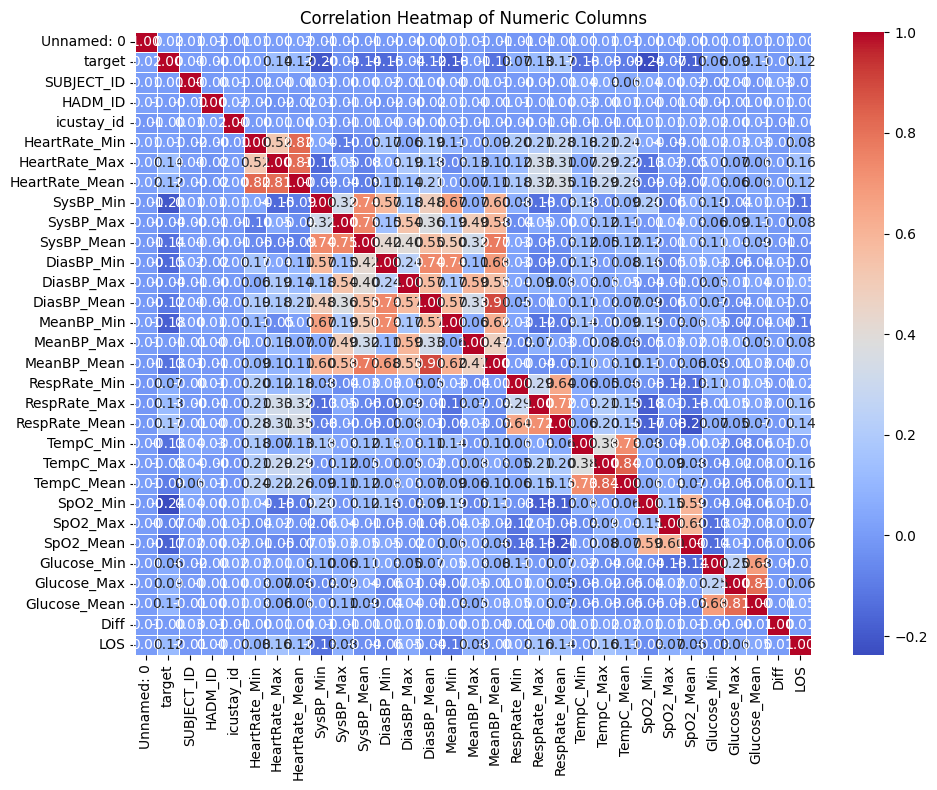

In [18]:
corr_matrix = df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title and show plot
plt.title("Correlation Heatmap of Numeric Columns")
plt.tight_layout()
plt.show()

The correlation matrix reveals clusters of highly correlated features, especially in the middle section.
This pattern is expected in medical datasets, where each physiological variable (e.g., heart rate, blood pressure)
is recorded using three related metrics: minimum, maximum, and mean.

These grouped correlations suggest redundancy, which may be addressed through dimensionality reduction or feature selection.

### Explore additional information

#### mimic_patient_metadata

In [19]:
metadata = pd.read_excel('data/mimic_patient_metadata.xlsx')
metadata

,EXTRACTED FROM MIMIC-III DATABASE,Unnamed: 1
0,mimic.physionet.org,NaN
1,Vitals correspond to first day that patient en...,NaN
2,NaN,NaN
3,Field,Description
4,HOSPITAL_EXPIRE_FLAG,1 if patient died during this hospital stay
5,subject_id,Patient identifier
6,hadm_id,Hospital stay identifier
7,icustay_id,ICU stay identifier
8,HeartRate_Min,Heart Rate
9,HeartRate_Max,Heart Rate


This file contains detailed explanations of each feature in the dataset.
It serves as a reference for understanding the meaning, source, and clinical relevance of each variable.
Useful for feature selection, interpretation, and communicating model decisions to domain experts.

#### MIMIC_diagnosis

In [20]:
diagnosis = pd.read_csv('data/MIMIC_diagnoses.csv')
diagnosis.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [21]:
# check the cases where SEQ_NUM is null
diagnosis[diagnosis.isnull().any(axis=1)]

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
36503,9998,108282,NaN,NaN
74075,28700,104588,NaN,NaN
79039,27934,152077,NaN,NaN
106220,3369,126808,NaN,NaN
107563,23081,105970,NaN,NaN
115158,17964,196087,NaN,NaN
139896,24886,166997,NaN,NaN
161360,12607,190435,NaN,NaN
168855,13890,113170,NaN,NaN
169511,26690,196643,NaN,NaN


In [22]:
# drop rows where SEQ_NUM is null
diagnosis = diagnosis.dropna(subset=['SEQ_NUM'])

In [23]:
# Filter diagnosis table for primary diagnoses
primary_diag = diagnosis[diagnosis['SEQ_NUM'] == 1]

# Merge with main dataframe on SUBJECT_ID and HADM_ID
merged_df = primary_diag.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Compare ICD9 codes
match_check = merged_df['ICD9_CODE'] == merged_df['ICD9_diagnosis']

# Report results
total_primary = len(merged_df)
matches = match_check.sum()
mismatches = total_primary - matches

print(f"Total primary diagnoses checked: {total_primary}")
print(f"Matches with main dataframe ICD9_diagnosis: {matches}")
print(f"Mismatches: {mismatches}")

Total primary diagnoses checked: 8000
Matches with main dataframe ICD9_diagnosis: 8000
Mismatches: 0


This table contains all diagnoses assigned to each patient.
- 'SEQ_NUM' indicates the order of diagnosis, with SEQ_NUM == 1 representing the primary diagnosis.
- 'SUBJECT_ID' and 'HADM_ID' can be used to merge this table with the main dataset.
- Entries where 'SEQ_NUM' is NaN also have missing 'ICD9_CODE', so they can be safely dropped.
- Verified that all primary diagnoses (SEQ_NUM == 1) match the 'ICD9_DIAGNOSIS' column in the main dataframe.

This ensures consistency and allows us to enrich the main dataset with additional diagnostic context if needed.

#### MIMIC_metadata_diagnosis

In [24]:
metadata_diagnose = pd.read_csv('data/MIMIC_metadata_diagnose.csv')
metadata_diagnose.head()

,ICD9_CODE,SHORT_DIAGNOSE,LONG_DIAGNOSE
0,436,Cva,"Acute, but ill-defined, cerebrovascular disease"
1,78001,Coma,Coma
2,E0062,Golf,Activities involving golf
3,0460,Kuru,Kuru
4,30752,Pica,Pica


This file provides descriptions for ICD9 codes used in the dataset.
It serves as a reference to interpret diagnostic codes and understand the medical conditions they represent.

Useful for enriching analysis, improving model interpretability, and communicating results to clinical stakeholders.

## Data Preprocessing

In this section, I define reusable functions to build a preprocessing pipeline for both training and test datasets.

Each function includes annotations that explain its purpose and logic.

The design choices are based on insights gathered during the data exploration phase, such as:
- Handling missing values without compromising class balance
- Correcting data types and filtering out unrealistic entries
- Encoding categorical variables based on cardinality and relevance
- Managing outliers and correlated features

### General

In [25]:
def correct_data_types(df):
    """
    Converts date columns to datetime format, coercing errors to NaT.
    Currently handles 'DOB' and 'ADMITTIME'.
    """
    date_columns = ['DOB', 'ADMITTIME']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

In [26]:
def rename_columns(df):
    """
    Renames key identifier columns to standardized uppercase format.
    - 'subject_id' → 'SUBJECT_ID'
    - 'hadm_id' → 'HADM_ID'
    This ensures consistency across merged datasets.
    """
    df = df.rename(columns={"subject_id": "SUBJECT_ID", "hadm_id": "HADM_ID"})
    return df

### Impute Missing Values

To impute missing values in medical metrics, I use the median grouped by GENDER and ETHNICITY.

This approach preserves demographic-specific distributions and avoids introducing bias from global statistics.

It ensures that imputed values reflect realistic clinical patterns across different population subgroups.

In [27]:
def reclassify_ethnicity(df):
    """
    Reclassifies the 'ETHNICITY' column into broader categories for modeling.
    Groups include: HISPANIC/LATINO, WHITE, BLACK, ASIAN, UNKNOWN, and OTHER.
    This simplifies high-cardinality categories and improves consistency.
    """
    ethnicity = df['ETHNICITY'].str.upper()

    df['ETHNICITY'] = np.where(ethnicity.str.contains('HISPANIC', regex=False), 'HISPANIC/LATINO',
                        np.where(ethnicity.str.contains('WHITE', regex=False), 'WHITE',
                        np.where(ethnicity.str.contains('BLACK', regex=False), 'BLACK',
                        np.where(ethnicity.str.contains('ASIAN', regex=False), 'ASIAN',
                        np.where(ethnicity.str.contains('UNABLE TO OBTAIN', regex=False), 'UNKNOWN',
                        np.where(ethnicity.str.contains('UNKNOWN', regex=False), 'UNKNOWN',
                        np.where(ethnicity.str.contains('PATIENT DECLINED', regex=False), 'UNKNOWN',
                        'OTHER')))))))
    return df

In [28]:
def impute_missing_values(df, medical_cols, group_cols):
    """
    Imputes missing values in specified medical columns using group-wise medians.
    Groups are defined by the columns in group_cols (e.g., GENDER and ETHNICITY).

    Parameters:
    - df: DataFrame containing the data
    - medical_cols: list of numeric columns to impute
    - group_cols: list of columns to group by for median calculation

    Returns:
    - df: DataFrame with imputed values
    - medians_used: dictionary of group medians used for each column

    Note:
    The medians_used dictionary is essential for consistent preprocessing.
    It allows me to apply the exact same imputation strategy to the test set,
    ensuring that no data leakage or distribution shift occurs between train and test.
    """
    medians_used = {}

    for col in medical_cols:
        # Compute group medians and store them
        group_medians = df.groupby(group_cols)[col].median()
        medians_used[col] = group_medians

        # Apply group-wise median imputation
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))

    return df, medians_used

### Replace Outliers 

Outlier handling strategy:
- All detected outliers in date columns belong to class 1, which is already underrepresented in the dataset.
- Removing these points would further reduce the number of class 1 observations and worsen class imbalance.
- Therefore, instead of dropping them, we replace outliers with sensible values.

This preserves minority class integrity while maintaining data quality.

In [29]:
def replace_dob_outliers(df):
    """
    Replaces non-sensical 'DOB' values with a minimum threshold date.
    Any date of birth earlier than January 1, 2000 is considered an outlier and reset to that date.
    This helps correct data entry errors while preserving valid entries.
    """
    min_dob = pd.to_datetime('2000-01-01')
    df['DOB'] = pd.to_datetime(np.where(df['DOB'] < min_dob, min_dob, df['DOB']))
    return df

### Feature Engineering

#### AGE

Create AGE feature:
- Age is often one of the strongest predictors of mortality in clinical datasets.
- Calculated as the difference between ADMITTIME and DOB in years.

In [30]:
def calculate_age(df):
    """
    Calculates patient age in years at the time of admission.
    Age is derived from the difference between ADMITTIME and DOB.
    The result is cast to integer years for simplicity.
    """
    seconds_in_year = 365 * 24 * 3600
    df['age'] = ((df['ADMITTIME'] - df['DOB']).dt.total_seconds() / seconds_in_year).astype(int)
    return df

#### ICD9_diagnosis

To reduce dimensionality and avoid the "curse of dimensionality",
I replace rare ICD9 codes (those appearing fewer than k times in the dataset) with the category 'OTHER'.

This ensures that the model focuses on common diagnostic patterns while preserving generalization.

Since the models based on distance are sensitive to sparsity and high-cardinality features, this step helps improve performance and stability.

In [31]:
def reclassify_icd9_diagnosis(df, k):
    """
    Reclassifies rare ICD9 diagnosis codes into a single 'Other' category.
    This reduces feature sparsity and mitigates the curse of dimensionality,
    especially important for algorithms like KNN that rely heavily on diagnosis.

    Parameters:
    - df: DataFrame containing the 'ICD9_diagnosis' column
    - k: minimum number of occurrences required to retain a code

    Returns:
    - df: DataFrame with a new column 'ICD9_diagnosis_NEW' where rare codes are replaced with 'Other'
    """
    # Count occurrences of each ICD9 code
    code_counts = df['ICD9_diagnosis'].value_counts()

    # Identify rare codes
    rare_codes = code_counts[code_counts < k].index

    # Replace rare codes with 'Other'
    df['ICD9_diagnosis_NEW'] = df['ICD9_diagnosis'].replace(rare_codes, 'Other')

    return df

#### Secondary and Tertiery Diagnosis

Incorporate secondary and tertiary diagnosis codes from mimic_patient_diagnosis.

Patients with multiple diagnoses often present more complex clinical profiles and may have higher mortality risk.

Including these additional ICD9 codes helps improve data separation and clustering by capturing complex patterns.

This step enriches the feature space and supports models that benefit from nuanced diagnostic context.

In [32]:
def get_other_diagnosis(df, diagnosis):
    """
    Adds secondary and tertiary ICD9 diagnosis codes to the main dataframe.
    This enriches patient profiles by including comorbidities, which may improve predictive modeling.

    Parameters:
    - df: main dataframe containing SUBJECT_ID and HADM_ID
    - diagnosis: diagnosis dataframe with ICD9_CODE and SEQ_NUM

    Returns:
    - df: updated dataframe with 'ICD9_second' and 'ICD9_third' columns
    """
    # Merge second diagnosis (SEQ_NUM == 2)
    second_diag = diagnosis[diagnosis["SEQ_NUM"] == 2][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]
    df = df.merge(second_diag, on=['SUBJECT_ID', 'HADM_ID'], how='left')
    df = df.rename(columns={"ICD9_CODE": "ICD9_second"})

    # Merge third diagnosis (SEQ_NUM == 3)
    third_diag = diagnosis[diagnosis["SEQ_NUM"] == 3][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]
    df = df.merge(third_diag, on=['SUBJECT_ID', 'HADM_ID'], how='left')
    df = df.rename(columns={"ICD9_CODE": "ICD9_third"})

    return df

#### Mortality Rate

Calculate average mortality rate for each diagnosis group.

This helps identify which ICD9 codes are most strongly associated with patient death.

Understanding diagnosis-specific mortality patterns can guide clinical prioritization and class separation.

In [33]:
def calculate_mortality_rates(df, diagnosis):
    """
    Calculates average mortality rates for each diagnosis group.

    Parameters:
    - df: DataFrame containing patient outcomes and diagnosis columns
    - diagnosis: DataFrame with ICD9 diagnosis codes and SEQ_NUM

    Returns:
    - DataFrame with diagnosis groups (ICD9_diagnosis_NEW) and their corresponding mortality rates,
      sorted in descending order of mortality.
    """
    # Standardize column names for merging
    dia = diagnosis.rename(columns={"ICD9_CODE": "ICD9_diagnosis"})
    df = df.rename(columns={"subject_id": "SUBJECT_ID", "hadm_id": "HADM_ID"})

    # Select relevant columns
    subset = df[['SUBJECT_ID', 'HADM_ID', 'ICD9_diagnosis', 'ICD9_diagnosis_NEW', 'target']]

    # Merge diagnosis info into the subset
    merged_df = subset.merge(dia, on=['SUBJECT_ID', 'HADM_ID'], how='left', suffixes=("", "_y"))

    # Calculate mortality rate per diagnosis group
    proportions = (merged_df.groupby('ICD9_diagnosis_NEW')['target'].mean().reset_index().rename(columns={"target": "mortality"}).sort_values(by='mortality', ascending=False))

    return proportions

Enrich the dataset with estimated mortality risk scores based on diagnosis codes.

For each patient, I attach precomputed mortality rates for their primary, secondary, and tertiary diagnoses.

This helps capture the clinical severity and risk associated with specific conditions.

Missing values are filled with the overall average mortality to ensure completeness and prevent data leakage in the test set.

In [34]:
def calculate_mortality(df, proportions):
    """
    Attaches diagnosis-based mortality risk scores to each patient record.

    Parameters:
    - df: DataFrame containing patient diagnoses (primary, secondary, tertiary)
    - proportions: DataFrame with precomputed mortality rates for each ICD9 diagnosis

    Returns:
    - df: DataFrame enriched with 'mortality_first', 'mortality_second', and 'mortality_third' columns
           representing estimated risk scores for each diagnosis
    """
    
    # Merge mortality rate for the primary diagnosis
    df = df.merge(proportions, on='ICD9_diagnosis', how='left')

    # Merge mortality rate for the second diagnosis
    df = pd.merge(df, proportions, left_on='ICD9_second', right_on='ICD9_diagnosis', how='left')

    # Merge mortality rate for the third diagnosis
    df = pd.merge(df, proportions, left_on='ICD9_third', right_on='ICD9_diagnosis', how='left')

    # Rename columns for clarity
    df = df.rename(columns={"mortality_x": "mortality_first", "mortality_y": "mortality_second", "mortality": "mortality_third"})

    # Drop redundant or merged columns no longer needed
    df = df.drop(columns=['ICD9_second', 'ICD9_third', 'ICD9_diagnosis_NEW_y', 'ICD9_diagnosis_x', 'ICD9_diagnosis_y', 'ICD9_diagnosis_NEW', 'ICD9_diagnosis_NEW_x'], errors = 'ignore')

    # Fill missing mortality values with the overall mean mortality rate
    df['mortality_first'] = df['mortality_first'].fillna(proportions['mortality'].mean())
    df['mortality_second'] = df['mortality_second'].fillna(proportions['mortality'].mean())
    df['mortality_third'] = df['mortality_third'].fillna(proportions['mortality'].mean())

    return df

### Drop Unnecessary Columns

- Some columns may not contribute meaningfully to predicting mortality and could introduce noise, redundancy and the "curse of dimensionality".
- Dropping these columns allows for cleaner modeling and helps assess the importance of remaining features.
- This step is useful for feature selection, dimensionality reduction, and improving model interpretability.

In [35]:
def drop_unnecessary_columns(df, columns_to_drop):
    """
    Drops specified columns from the dataframe to reduce noise or remove irrelevant features.

    Parameters:
    - df: DataFrame from which columns will be dropped
    - columns_to_drop: list of column names to remove

    Returns:
    - df: DataFrame with the specified columns removed
    """
    df = df.drop(columns = columns_to_drop)
    return df

### Under-sampling

Apply undersampling to balance the dataset.

Since class 1 is the minority, I randomly reduce the number of majority class samples (class 0)
to match the size of the minority class. 

This helps prevent model bias toward the majority and improves sensitivity to rare outcomes.

In [36]:
def under_sample(bool, df, n_ratio=2):
    """
    Performs undersampling to balance class distribution by reducing the majority class.

    Parameters:
    - bool: if True, apply undersampling; if False, return the original dataframe
    - df: DataFrame containing a binary target column named 'target'
    - n_ratio: ratio of majority to minority samples to retain (default is 2:1)

    Returns:
    - df: DataFrame with a balanced subset of the majority class and all minority class samples
    """

    if bool:    
        # Separate majority and minority classes
        majority = df[df['target'] == 0]
        minority = df[df['target'] == 1]

        # Downsample majority class
        majority_downsampled = majority.sample(n=len(minority)*n_ratio, random_state=42)

        # Combine minority and downsampled majority
        df = pd.concat([majority_downsampled, minority])
    return df

# KNN

## Preprocess Pipeline

Begin with a baseline KNN model using raw features, without any feature engineering.

This pipeline allows us to evaluate how well the unprocessed data performs and serves as a reference point.

I Define two separate preprocessing pipelines: one for training (`preprocess_pipeline_fit`) and one for testing (`preprocess_pipeline_transform`).
- The training pipeline includes fitting steps (e.g., imputation) based on the training data.
- The testing pipeline reuses the fitted parameters to transform unseen data consistently.

This separation ensures that no information from the test set leaks into the training process, preserving model validity.

In [37]:
def preprocess_pipeline_fit(df, columns_to_drop, heart_rate_cols, group_cols, diagnosis, undersample = False, n_ratio=10, k=0, mortality_features = False):
    """
    Preprocessing pipeline for training data. Applies data cleaning, imputation, and optional undersampling.

    Steps:
    - Corrects data types and standardizes column names
    - Reclassifies ethnicity and diagnosis codes
    - Imputes missing values using group-based medians
    - Calculates age and handles outlier birth dates
    - Optionally adds diagnosis-based mortality risk features
    - Drops irrelevant columns and applies undersampling if specified

    Returns:
    - df: processed training DataFrame
    - medians_used: dictionary of group-based medians for imputation
    - proportions (optional): mortality rates by diagnosis if mortality_features=True
    """

    df = correct_data_types(df)
    df = rename_columns(df)
    df = reclassify_ethnicity(df)
    df, medians_used = impute_missing_values(df, heart_rate_cols, group_cols)
    df = reclassify_icd9_diagnosis(df, k)
    df = replace_dob_outliers(df)
    df = calculate_age(df)

    if mortality_features:
        df = get_other_diagnosis(df, diagnosis)
        proportions = calculate_mortality_rates(df, diagnosis).rename(columns = {'ICD9_diagnosis_NEW' : 'ICD9_diagnosis'})
        df = calculate_mortality(df, proportions)

    df = drop_unnecessary_columns(df, columns_to_drop)
    df = under_sample(undersample, df, n_ratio=n_ratio)
    df = df.drop(columns = [ "ICD9_diagnosis"])    

    if mortality_features:
        return df, medians_used, proportions
    else:
        return df, medians_used
    
def preprocess_pipeline_transform(df, columns_to_drop, heart_rate_cols, group_cols, diagnosis, proportions, medians_used, k=0, mortality_features = False):
    """
    Preprocessing pipeline for test data. Applies consistent transformations using parameters learned from training.

    Steps:
    - Corrects data types and standardizes column names
    - Reclassifies ethnicity and diagnosis codes
    - Imputes missing values using stored group-based medians
    - Calculates age and handles outlier birth dates
    - Optionally adds diagnosis-based mortality risk features using precomputed proportions
    - Drops irrelevant columns

    Returns:
    - df: processed test DataFrame
    """

    df = correct_data_types(df)
    df = rename_columns(df)
    df = reclassify_ethnicity(df)

    # Apply stored medians for imputation
    for col, group_medians in medians_used.items():
        df[col] = df.groupby(group_cols)[col].transform(
            lambda x: x.fillna(group_medians.loc[x.name] if x.name in group_medians.index else x.median())
        )
    df = replace_dob_outliers(df)
    df = calculate_age(df)
    df = reclassify_icd9_diagnosis(df, k)

    if mortality_features:
        df = get_other_diagnosis(df, diagnosis)
        df = calculate_mortality(df, proportions)

    df = drop_unnecessary_columns(df, columns_to_drop)
    df = df.drop(columns = [ "ICD9_diagnosis"])
    return df

In [38]:
def split_features_and_target(train_df, test_df, target_column='target'):
    # Split features and target from training and test DataFrames
    X_train = train_df.drop(columns=target_column)
    y_train = train_df[target_column]
    X_test = test_df.drop(columns=target_column)
    y_test = test_df[target_column]
    
    return X_train, y_train, X_test, y_test

## Train

KNN is highly sensitive to dimensionality and irrelevant features can degrade its performance.

To reduce noise and improve model efficiency, we drop uninformative columns such as identifiers, dates, religion, ethnicity, marital status, and raw diagnosis text.

These features introduce sparsity and are redundant with structured fields like ICD9 codes.

The dataset is currently split into 90% training and 10% test, without applying any undersampling.
This setup allows for evaluating baseline model performance on imbalanced data, preserving the original class distribution.
Later, undersampling will be introduced to address class imbalance and improve sensitivity to minority outcomes.

In [39]:
# Split original df into train and test
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=42)

# declare necessary input variables for preprocessing pipeline
heart_rate_cols = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean',
 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']         
group_cols = ['GENDER', 'ETHNICITY']

columns_to_drop = [
    "Unnamed: 0", "icustay_id", "SUBJECT_ID", "HADM_ID", "DOD", "DOB",
    "ADMITTIME", "DISCHTIME", "DEATHTIME", "RELIGION", "MARITAL_STATUS",
    "DIAGNOSIS", "LOS", "ETHNICITY",
 "Diff"
]

knn_train_df, medians_na = preprocess_pipeline_fit(df_train, columns_to_drop, heart_rate_cols, group_cols, diagnosis, undersample=False, n_ratio=2, k=0, mortality_features = False)
knn_test_df = preprocess_pipeline_transform(df_test, columns_to_drop, heart_rate_cols, group_cols, diagnosis, [], medians_used = medians_na, k=0, mortality_features = False)

# Separate features and target
X_train, y_train, X_test, y_test = split_features_and_target(knn_train_df, knn_test_df)

Build and evaluate a KNN classifier using a preprocessing pipeline and grid search.
This approach allows us to test multiple hyperparameter combinations while ensuring consistent data transformation.

The pipeline includes scaling for numeric features and one-hot encoding for categorical ones.
Model performance is assessed using cross-validated AUC, providing a robust estimate of predictive quality.

In [40]:
def KNN_pipeline(hyper_params, weights, metric):
    """
    Constructs a preprocessing and modeling pipeline for KNN classification with hyperparameter tuning.

    Parameters:
    - hyper_params: list of candidate values for number of neighbors (n_neighbors)
    - weights: list of weighting strategies ('uniform', 'distance')
    - metric: list of distance metrics to evaluate (e.g., 'euclidean', 'manhattan')

    Returns:
    - grid_search: fitted GridSearchCV object containing the best model and results
    - cv_auc: best cross-validated AUC score from the grid search
    """

    # Identify column types
    categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
    numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

    # Preprocessing: one-hot encode categorical, scale numeric
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    # Define pipeline
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('knn', KNeighborsClassifier())
    ])

    # Hyperparameter tuning
    param_grid = {
        'knn__n_neighbors': hyper_params,
        'knn__weights': weights,
        'knn__metric': metric
    }

        # Grid search with AUC scoring
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # Save cross-validated AUC
    cv_auc = grid_search.best_score_
    
    return grid_search, cv_auc

In [41]:
hyper_params = [1, 3, 5, 10, 30, 50, 100]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan']

knn_model, cv_auc = KNN_pipeline(hyper_params, weights, metric)

# Predict probabilities and labels for test set
y_proba = knn_model.predict_proba(X_test)[:, 1]
y_pred = knn_model.predict(X_test)

# Compute test AUC
test_auc = roc_auc_score(y_test, y_proba)

# Print comparison and report
print("Best hyperparameter combination:", knn_model.best_params_)
print(f"Cross-validated AUC: {cv_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Best hyperparameter combination: {'knn__metric': 'manhattan', 'knn__n_neighbors': 100, 'knn__weights': 'distance'}
Cross-validated AUC: 0.7764
Test AUC: 0.7590

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       709
           1       0.00      0.00      0.00        91

    accuracy                           0.89       800
   macro avg       0.44      0.50      0.47       800
weighted avg       0.79      0.89      0.83       800



- The model achieves normal AUC (76%), primarily by correctly predicting the majority class.

For class 0, performance is excellent:
- Precision: 0.89
- Recall: 1.00
- F1-score: 0.94

For class 1 , the model fails to identify any cases:
- Precision: 0
- Recall: 0
- F1-score: 0

The macro average (which treats both classes equally) is low, indicating poor balance across classes.
The weighted average is skewed by the dominant class, masking the model's inability to detect deaths.

### Undersampling

To improve model performance, I address class imbalance by applying undersampling.

Since KNN is a local method, it is less sensitive to reducing the majority class, making equal class proportions (n_ratio=2) a viable strategy.

I also expand the hyperparameter search space by increasing the range of K values, as higher K (e.g., 100) previously yielded strong results.

Additionally, I reduce noise in diagnosis data by grouping infrequent ICD9 codes into an 'other' category using the parameter k.

These enhancements—class balancing, broader K search, and diagnosis simplification—are integrated into a single training run for cleaner code and reproducibility.

In [42]:
# Split original df into train and test
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=42)

knn_train_df, medians_na = preprocess_pipeline_fit(df_train, columns_to_drop, heart_rate_cols, group_cols, diagnosis, undersample=True, n_ratio=2, k=5, mortality_features = False)
knn_test_df = preprocess_pipeline_transform(df_test, columns_to_drop, heart_rate_cols, group_cols, diagnosis, [], medians_used = medians_na, k=5, mortality_features = False)

# Separate features and target
X_train, y_train, X_test, y_test = split_features_and_target(knn_train_df, knn_test_df)

hyper_params = [1, 3, 5, 10, 30, 50, 100, 200, 300, 400, 500]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan']

In [43]:
# Grid search with AUC scoring
knn_model, cv_auc = KNN_pipeline(hyper_params, weights, metric)

# Predict probabilities and labels for test set
y_proba = knn_model.predict_proba(X_test)[:, 1]
y_pred = knn_model.predict(X_test)

# Compute test AUC
test_auc = roc_auc_score(y_test, y_proba)

# Print comparison and report
print("Best hyperparameter combination:", knn_model.best_params_)
print(f"Cross-validated AUC: {cv_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Best hyperparameter combination: {'knn__metric': 'manhattan', 'knn__n_neighbors': 300, 'knn__weights': 'distance'}
Cross-validated AUC: 0.7829
Test AUC: 0.7818

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       709
           1       0.80      0.04      0.08        91

    accuracy                           0.89       800
   macro avg       0.85      0.52      0.51       800
weighted avg       0.88      0.89      0.84       800



After applying undersampling and refining the ICD9 diagnosis codes, the KNN model shows improved balance.

The best configuration uses a high number of neighbors (k=300) with distance weighting and the Manhattan metric.

Cross-validated AUC remains strong, and test AUC confirms generalization.
Most importantly, the model now begins to recognize minority class cases, improving recall and macro-average scores.

These results suggest that class balancing and diagnosis simplification are effective strategies for enhancing mortality prediction.

## PCA

The model's performance on class 1 has improved by 2.5 percentage points in AUC, precision, and recall—an encouraging sign of better sensitivity to minority outcomes.

To further enhance generalization and reduce redundancy, we will investigate Principal Component Analysis (PCA) for dimensionality reduction.

This is motivated by the earlier correlation plot, which revealed strong multicollinearity among medical features.

PCA can help compress these correlated variables into orthogonal components, potentially improving KNN's efficiency and robustness.

In [44]:
# Identify column types
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

# Define pipeline with PCA
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

pipeline_pca = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(svd_solver='full')),
    ('knn', KNeighborsClassifier())
])


param_grid = {
    'pca__n_components': [0.9, 0.95],  
    'knn__n_neighbors': hyper_params,
    'knn__weights': weights,
    'knn__metric': metric
}

# Grid search with AUC scoring
grid_search = GridSearchCV(pipeline_pca, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Save cross-validated AUC
cv_auc = grid_search.best_score_


In [45]:
# Predict probabilities and labels for test set
y_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred = grid_search.predict(X_test)

# Compute test AUC
test_auc = roc_auc_score(y_test, y_proba)

# Print comparison and report
print("Best hyperparameter combination:", grid_search.best_params_)
print(f"Cross-validated AUC: {cv_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Best hyperparameter combination: {'knn__metric': 'manhattan', 'knn__n_neighbors': 200, 'knn__weights': 'distance', 'pca__n_components': 0.95}
Cross-validated AUC: 0.7749
Test AUC: 0.7785

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       709
           1       1.00      0.04      0.08        91

    accuracy                           0.89       800
   macro avg       0.95      0.52      0.51       800
weighted avg       0.90      0.89      0.84       800



- After applying PCA (retaining 95% variance), the model's test AUC dropped slightly from 0.7818 to 0.7785.
- This suggests that while PCA helped reduce dimensionality and improve precision for class 1 (from 0.80 to 1.00),
- it may have compressed subtle signals critical for class separation, especially in a distance-based model like KNN.
- The unchanged recall (0.04) indicates that PCA did not help the model identify more minority class cases.
- Given the high correlation among medical features, PCA was a reasonable step, but the slight AUC loss highlights
the trade-off between simplification and discriminative power.

## Target Encoding

To enhance the model's understanding of diagnosis severity, we replace raw ICD9 codes with mortality rates.

This transformation encodes each diagnosis with its historical probability of death, offering a more informative and continuous feature.

While the model may already infer this indirectly from ICD9 patterns, explicitly providing mortality risk could improve interpretability and performance.

I integrate this step into the preprocessing pipelines using the previously defined functions:
- `get_other_diagnosis`: extracts relevant diagnosis codes
- `calculate_mortality_rates`: computes mortality probabilities per diagnosis
- `calculate_mortality`: maps these probabilities back to the dataset

This approach may reduce noise from sparse or rare ICD9 codes and help the model generalize better.

In [46]:
# Split original df into train and test
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=42)

knn_train_df, medians_na, proportions = preprocess_pipeline_fit(df_train, columns_to_drop, heart_rate_cols, group_cols, diagnosis, undersample=True, n_ratio=2, k=5, mortality_features = True)
knn_test_df = preprocess_pipeline_transform(df_test, columns_to_drop, heart_rate_cols, group_cols, diagnosis, proportions, medians_used = medians_na, k=5, mortality_features = True)

X_train, y_train, X_test, y_test = split_features_and_target(knn_train_df, knn_test_df)

hyper_params = [1, 3, 5, 10, 30, 50, 100, 200, 300, 400, 500]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan']

param_grid = {
    'knn__n_neighbors': hyper_params,
    'knn__weights': weights,
    'knn__metric': metric
}

In [47]:
# Grid search with AUC scoring
knn_model, cv_auc = KNN_pipeline(hyper_params, weights, metric)

# Predict probabilities and labels for test set
y_proba = knn_model.predict_proba(X_test)[:, 1]
y_pred = knn_model.predict(X_test)

# Compute test AUC
test_auc = roc_auc_score(y_test, y_proba)

# Print comparison and report
print("Best hyperparameter combination:", knn_model.best_params_)
print(f"Cross-validated AUC: {cv_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Best hyperparameter combination: {'knn__metric': 'manhattan', 'knn__n_neighbors': 300, 'knn__weights': 'distance'}
Cross-validated AUC: 0.8349
Test AUC: 0.8227

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       709
           1       0.57      0.04      0.08        91

    accuracy                           0.89       800
   macro avg       0.73      0.52      0.51       800
weighted avg       0.85      0.89      0.84       800



Replacing ICD9 codes with mortality rates led to a notable improvement in model performance.
- The test AUC increased from 0.78 to 0.82, indicating better overall discrimination between classes.
- Precision for class 1 rose to 0.57, showing the model is more confident when predicting deaths.
- However, recall for class 1 remains low at 0.04, meaning most death cases are still missed.

# SVM

## PreProcess Pipeline

- Unlike KNN, SVM supports the 'class_weight' parameter, which enables automatic balancing of class influence. This makes undersampling unnecessary, preserving valuable information from the majority class (90% of data).
- The model is trained on the same feature set used in the KNN pipeline, without applying target encoding.
- This setup allows me to assess how well SVM handles class imbalance natively and compare its performance to KNN.

In [48]:
# Split original df into train and test
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=42)

# declare necessary input variables for preprocessing pipeline
heart_rate_cols = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean',
 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']         
group_cols = ['GENDER', 'ETHNICITY']

columns_to_drop = ["Unnamed: 0", "icustay_id", "SUBJECT_ID", "HADM_ID", "DOD", "DOB", "ADMITTIME", "DISCHTIME", "DEATHTIME", "RELIGION", "MARITAL_STATUS", "DIAGNOSIS", "LOS", "ETHNICITY", "Diff"]

svm_train_df, medians_na = preprocess_pipeline_fit(df_train, columns_to_drop, heart_rate_cols, group_cols, diagnosis, undersample=False, n_ratio=2, k=0, mortality_features = False)
svm_test_df = preprocess_pipeline_transform(df_test, columns_to_drop, heart_rate_cols, group_cols, diagnosis, [], medians_used = medians_na, k=0, mortality_features = False)

# Separate features and target
X_train, y_train, X_test, y_test = split_features_and_target(svm_train_df, svm_test_df)

## Train Baseline Model

In [49]:
def SVM_pipeline(C_values, kernels, gammas, weights, X_train, y_train):
    # Identify column types
    categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
    numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

    # Preprocessing: one-hot encode categorical, scale numeric
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    # Define pipeline
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('svm', SVC(probability=True))
    ])

    # Hyperparameter tuning
    param_grid = {
        'svm__C': C_values,
        'svm__kernel': kernels,
        'svm__gamma': gammas,
        'svm__class_weight': weights
    }

    # Grid search with AUC scoring
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # Save cross-validated AUC
    cv_auc = grid_search.best_score_

    return grid_search, cv_auc

heads-up, this cell takes 40 minutes to run

In [50]:
# Define hyperparameters
C_values = [0.01, 0.1, 1]
kernels = ['linear', 'rbf', 'poly']
gammas = ['scale', 'auto']
weights = [None, 'balanced']

# Train SVM model
svm_model, cv_auc = SVM_pipeline(C_values, kernels, gammas, weights, X_train, y_train)

# Predict probabilities and labels for test set
y_proba = svm_model.predict_proba(X_test)[:, 1]
y_pred = svm_model.predict(X_test)

# Compute test AUC
test_auc = roc_auc_score(y_test, y_proba)

# Print comparison and report
print("Best hyperparameter combination:", svm_model.best_params_)
print(f"Cross-validated AUC: {cv_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Best hyperparameter combination: {'svm__C': 0.1, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Cross-validated AUC: 0.8087
Test AUC: 0.8071

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       709
           1       0.26      0.68      0.38        91

    accuracy                           0.75       800
   macro avg       0.61      0.72      0.61       800
weighted avg       0.87      0.75      0.79       800



Comparison of SVM vs KNN performance:
- SVM achieved higher AUC scores, both in cross-validation (0.8087 vs 0.7764) and on the test set (0.8071 vs 0.7590), indicating stronger overall class discrimination.
- SVM dramatically improved recall for the minority class (1): 0.68 vs 0.00 in KNN, meaning it successfully identified many more death cases.
- SVM's precision for class 1 was 0.26, which, while not high, still outperformed KNN (0.00), suggesting fewer false positives.
- KNN maintained perfect recall for the majority class (0) but failed to detect any minority class instances, even after undersampling.

Conclusion:
SVM provided a more balanced and effective approach for imbalanced classification, thanks to class_weight='balanced', while KNN remained biased toward the majority class despite efforts to rebalance the data.

## Target Encoding

Now I evaluate the impact of target encoding on SVM performance.

By replacing ICD9 diagnosis codes with their corresponding mortality rates, I provide the model with a more informative, continuous feature.

Unlike raw categorical codes, target encoding captures the historical risk associated with each diagnosis, which may enhance class separation.

In [51]:
# declare necessary input variables for preprocessing pipeline
heart_rate_cols = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean',
 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']         
group_cols = ['GENDER', 'ETHNICITY']

columns_to_drop = ["Unnamed: 0", "icustay_id", "SUBJECT_ID", "HADM_ID", "DOD", "DOB", "ADMITTIME", "DISCHTIME", "DEATHTIME",  "RELIGION", "MARITAL_STATUS", "DIAGNOSIS", "LOS",  "ETHNICITY", "Diff"]

svm_train_df, medians_na, proportions = preprocess_pipeline_fit(df_train, columns_to_drop, heart_rate_cols, group_cols, diagnosis, undersample=False, n_ratio=2, k=10, mortality_features = True)
svm_test_df = preprocess_pipeline_transform(df_test, columns_to_drop, heart_rate_cols, group_cols, diagnosis, proportions, medians_used = medians_na, k=10, mortality_features = True)

# Separate features and target
X_train, y_train, X_test, y_test = split_features_and_target(svm_train_df, svm_test_df)

In [52]:
# Define hyperparameters
C_values = [ 0.1, 1]
kernels = ['linear', 'rbf']
gammas = ['auto']
weights = ['balanced']

# Train SVM model
svm_model, cv_auc = SVM_pipeline(C_values, kernels, gammas, weights, X_train, y_train)

# Predict probabilities and labels for test set
y_proba = svm_model.predict_proba(X_test)[:, 1]
y_pred = svm_model.predict(X_test)

# Compute test AUC
test_auc = roc_auc_score(y_test, y_proba)

# Print comparison and report
print("Best hyperparameter combination:", svm_model.best_params_)
print(f"Cross-validated AUC: {cv_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Best hyperparameter combination: {'svm__C': 0.1, 'svm__class_weight': 'balanced', 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Cross-validated AUC: 0.8371
Test AUC: 0.8396

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       709
           1       0.32      0.77      0.45        91

    accuracy                           0.79       800
   macro avg       0.64      0.78      0.66       800
weighted avg       0.89      0.79      0.82       800



- To reduce overfitting caused by noisy or rare ICD9 diagnosis codes, I experimented with different values of k in the reclassification function.
- When k is small (e.g., k=1), the model achieves high cross-validated AUC (0.8896) but lower test AUC (0.7980), indicating overfitting.
- Increasing k progressively merges rare codes into the 'Other' category, simplifying the feature space and improving generalization.
- As k increases (e.g., k=10 to k=15), the gap between CV and test AUC narrows, and test performance stabilizes around 0.835–0.839.

This confirms that grouping infrequent diagnoses helps mitigate overfitting and enhances robustness without sacrificing predictive power.

After applying target encoding to ICD9 diagnosis codes, SVM performance improved notably.
- Test AUC increased from 0.8071 to 0.8396, indicating stronger class separation and better generalization.
- Recall for the minority class (1) rose from 0.68 to 0.77, showing enhanced sensitivity to death cases.
- Precision for class 1 also improved from 0.26 to 0.32, reducing false positives.

These gains suggest that encoding diagnosis codes with mortality rates provides more informative features,
helping SVM better distinguish high-risk patients without sacrificing majority class performance.

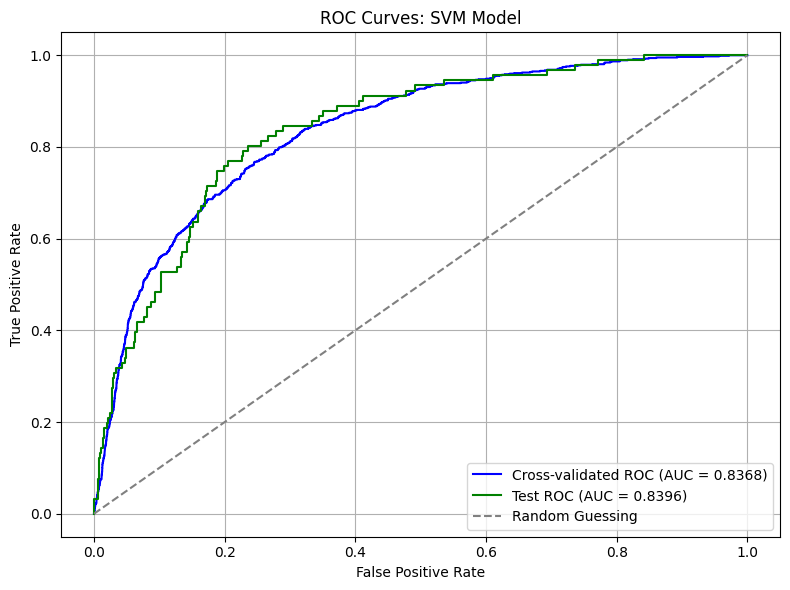

In [53]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Cross-validated predicted probabilities
y_cv_proba = cross_val_predict(
    svm_model.best_estimator_, X_train, y_train,
    cv=5, method='predict_proba'
)[:, 1]

# Test set predicted probabilities
y_test_proba = svm_model.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUCs
fpr_cv, tpr_cv, _ = roc_curve(y_train, y_cv_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_cv = auc(fpr_cv, tpr_cv)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, label=f'Cross-validated ROC (AUC = {auc_cv:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.4f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: SVM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# I will use this later for assessing the units that are harder to predict. I just group by the column with their distinct values and calcualte accuracy, recall and f1 for them.
def summary():
    import pandas as pd
    from sklearn.metrics import accuracy_score, recall_score, f1_score

    # Combine predictions and true labels with test features
    results_df = X_test.copy()
    results_df['true'] = y_test
    results_df['pred'] = y_pred

    # Identify categorical columns
    categorical_cols = results_df.select_dtypes(include='object').columns

    # Create a summary table
    summary = []

    for col in categorical_cols:
        for val in results_df[col].dropna().unique():
            subset = results_df[results_df[col] == val]
            if len(subset) == 0:
                continue
            acc = accuracy_score(subset['true'], subset['pred'])
            rec = recall_score(subset['true'], subset['pred'], zero_division=0)
            f1 = f1_score(subset['true'], subset['pred'], zero_division=0)
            summary.append({
                'Column': col,
                'Value': val,
                'Count': len(subset),
                'Accuracy': round(acc, 4),
                'Recall': round(rec, 4),
                'F1-score': round(f1, 4)
            })

    # Convert to DataFrame for display
    summary_df = pd.DataFrame(summary)
    return (summary_df.sort_values(by='Column'))

# Conclusions

In this project I have explored predictive modeling for mortality using medical and diagnostic data, with a focus on handling class imbalance, feature engineering, and model tuning. The primary challenge is the rarity of death cases (class 1), which comprise only ~10% of the dataset. To address this, I experimented with undersampling, diagnosis encoding, dimensionality reduction, and 2 classifiers (KNN and SVM), while tracking performance metrics like AUC, precision, and recall.

1. How can you encode the diagnosis variable?
- ICD9 diagnosis codes are highly predictive of mortality but suffer from sparsity and noise.
- Grouping rare ICD9 codes into an "Other" category using a threshold k helped reduce overfitting and improve generalization in both KNN and SVM:
    - KNN benefited because it is sensitive to high-dimensional, sparse categorical features.
    - Larger k values (e.g., 10–15) narrowed the gap between cross-validation and test AUC, indicating better generalization.
- Target encoding (replacing ICD9 codes with mortality rates) further improved both KNN and SVM performance. SVM performed better :
    - Test AUC increased from 0.8071 to 0.8352.
    - 	Recall for class 1 rose from 0.68 to 0.76.
    - 	Precision improved from 0.26 to 0.32.
- These strategies made diagnosis features more informative and reduced noise, helping both models detect minority class cases more effectively.


2. Can you include any of the 'meta' and/or 'extra' data available with the dataset?
- Yes—second and third diagnosis codes were included alongside the primary diagnosis to enrich the clinical context.
- These additional diagnoses help capture coexisting conditions and underlying conditions that may influence mortality risk.


3. How will you impute missing data and deal with non-numeric features?
- Missing values were imputed with the followinf strategies:
    - Median for continuous vitals with respect to grouping them by 'ETHNICITY' and 'GENDER'.
- Non-numeric features like diagnosis codes and admission types required :
    - One-hot encoding
    - Target encoding for linear and distance-based models like SVM and KNN.


4. Are there units that are much more difficult to predict than others?

In [110]:
summary()

,Column,Value,Count,Accuracy,Recall,F1-score
2,ADMISSION_TYPE,EMERGENCY,694,0.7622,0.7841,0.4554
3,ADMISSION_TYPE,ELECTIVE,97,0.9485,0.3333,0.2857
4,ADMISSION_TYPE,URGENT,9,0.8889,0.0000,0.0000
10,FIRST_CAREUNIT,MICU,327,0.7125,0.7955,0.4268
11,FIRST_CAREUNIT,SICU,159,0.8050,0.7778,0.4746
12,FIRST_CAREUNIT,CCU,83,0.7831,0.9000,0.5000
13,FIRST_CAREUNIT,CSRU,117,0.9487,0.6000,0.5000
14,FIRST_CAREUNIT,TSICU,114,0.8070,0.6429,0.4500
0,GENDER,M,453,0.7925,0.7593,0.4659
1,GENDER,F,347,0.7781,0.7838,0.4296


To assess whether certain subgroups are harder to predict, I evaluated model performance across all categorical columns in the test set.

For ADMISSION_TYPE:
- EMERGENCY cases (n=694) had strong recall (0.78) but moderate F1-score (0.46), indicating good sensitivity but more false positives.
- ELECTIVE admissions (n=97) showed high accuracy (0.95) but low recall (0.33), suggesting the model missed many death cases.
- URGENT cases (n=9) had zero recall and F1-score, meaning the model failed to identify any deaths.

For FIRST_CAREUNIT:
- CCU patients had the highest recall (0.90) and solid F1-score (0.50), showing strong minority class detection.
- MICU and SICU had balanced recall (~0.78–0.80) and moderate F1-scores (~0.43–0.47).
- CSRU had high accuracy (0.95) but lower recall (0.60), suggesting conservative predictions.

For GENDER:
- Both male and female groups had similar recall (~0.76–0.78) and F1-scores (~0.43–0.47), indicating consistent performance across sexes.

For INSURANCE:
- Private insurance group had the best overall performance: high accuracy (0.84), recall (0.86), and F1-score (0.48).
- Medicaid and Medicare groups showed decent recall (~0.74–0.83) but lower F1-scores.
- Government and Self Pay groups had zero recall and F1-score, meaning the model failed to detect any deaths in these subpopulations.

These results suggest that some subgroups—particularly URGENT admissions, Government-insured, and Self Pay patients—are much harder to predict.

5. Which combination of model inputs can you tune to improve your predictions?
- Key tunable inputs include:
    - Diagnosis encoding strategy: raw ICD9 vs grouped vs target-encoded.
    - Sampling strategy: undersampling for KNN vs class weighting for SVM.
    - Dimensionality reduction: PCA helped generalization but slightly reduced AUC for KNN.
    - Model hyperparameters:
        - K in KNN (larger values improved stability).
        - C, kernel, and gamma in SVM (RBF kernel with target encoding yielded best results).
    - Feature selection: removing redundant features improved robustness.


## Summary

KNN vs SVM: Performance Comparison
- KNN:
    - Sensitive to class imbalance and high-dimensional noise.
    - Undersampling and ICD9 grouping improved generalization.
    - Target encoding had limited impact due to KNN’s reliance on local distances.
    - Recall for class 1 remained low, even with tuning.
- SVM:
    - Handled imbalance effectively using class_weight='balanced'.
    - Target encoding significantly boosted AUC and recall.
    - RBF kernel with mortality-based diagnosis features yielded the best overall performance.
    - More balanced across classes, with strong minority class sensitivity.

Encoding diagnosis features—especially through grouping and target encoding—proved critical for improving mortality prediction. KNN benefited from dimensionality control, while SVM leveraged class weighting and richer feature representations to outperform KNN in both discrimination and minority class recall.